# **DATA ENGINEERING**

# Import Libraries

In [398]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import recall_score, accuracy_score, make_scorer, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Functions

In [399]:
def constrained_rfa(X, y, model, min_accuracy=0.775, max_features=15):
    remaining = list(X.columns)
    selected = []
    best_recall = 0
    
    while len(selected) < max_features:
        recalls = {}
        accuracies = {}
        
        for feature in remaining:
            temp_features = selected + [feature]
            model.fit(X[temp_features], y)
            y_pred = model.predict(X[temp_features])
            
            recalls[feature] = recall_score(y, y_pred)
            accuracies[feature] = accuracy_score(y, y_pred)
        
        # Filter features meeting accuracy constraint
        valid_features = [f for f in recalls if accuracies[f] >= min_accuracy]
        
        if not valid_features:
            break  # Stop if no features meet constraints
            
        # Select feature with highest recall among valid candidates
        best_feature = max(valid_features, key=lambda x: recalls[x])
        selected.append(best_feature)
        remaining.remove(best_feature)
        best_recall = recalls[best_feature]
        
    return selected

In [400]:
def recall_with_accuracy_constraint(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    if accuracy > 0.775:  # Your threshold
        return recall  # Prioritize recall if accuracy is acceptable
    else:
        return -1  # Penalize if accuracy is too low

# Wrap the scorer for sklearn
custom_scorer = make_scorer(recall_with_accuracy_constraint)

# Import the data

In [401]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
file_path = 'Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

In [402]:
needs_df.head()

,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
0,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
1,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
2,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
3,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
4,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


# Encoding

In [403]:
needs_df["Wealth"] = np.log1p(needs_df["Wealth"])
needs_df["Income"] = np.sqrt(needs_df["Income"])
needs_df = pd.get_dummies(needs_df, columns=['Gender'], prefix='Gender')

In [404]:
"""Standard_Scaler_features = ["Age", "RiskPropensity", "FinancialEducation", "Wealth", "Income"]
scaler = StandardScaler()
needs_df[Standard_Scaler_features] = scaler.fit_transform(needs_df[Standard_Scaler_features])"""

'Standard_Scaler_features = ["Age", "RiskPropensity", "FinancialEducation", "Wealth", "Income"]\nscaler = StandardScaler()\nneeds_df[Standard_Scaler_features] = scaler.fit_transform(needs_df[Standard_Scaler_features])'

# Accumulation Investment

## Preparation of the dataset

In [405]:
df_accumulation = needs_df.copy()
df_accumulation = df_accumulation.drop(columns=['IncomeInvestment'])
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Gender_0,Gender_1
0,60,2,0.228685,0.233355,8.257210,3.993789,1,True,False
1,78,2,0.358916,0.170911,4.669860,4.916691,0,True,False
2,33,2,0.317515,0.249703,4.822110,4.209215,1,False,True
3,69,4,0.767685,0.654597,12.891433,6.006347,1,False,True
4,58,3,0.429719,0.349039,4.602904,4.092876,0,True,False


In [406]:
df_accumulation.corr(numeric_only=True)[['AccumulationInvestment']]

,AccumulationInvestment
Age,-0.013512
FamilyMembers,0.066606
FinancialEducation,0.067965
RiskPropensity,0.068420
Income,0.320306
Wealth,0.119486
AccumulationInvestment,1.000000
Gender_0,0.010783
Gender_1,-0.010783


## Create all the features

In [408]:
features_base = df_accumulation.columns
print("Base features: ", features_base)

Base features:  Index(['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity',
       'Income', 'Wealth', 'AccumulationInvestment', 'Gender_0', 'Gender_1'],
      dtype='object')


In [397]:
feature_combinations = {
    'Wealth / Income': lambda df: df['Wealth'] * df['Income'],
    'RiskPropensity * Wealth': lambda df: df['RiskPropensity'] * df['Wealth'],
    'FinancialEducation * RiskPropensity': lambda df: df['FinancialEducation'] * df['RiskPropensity'],
    'Age / FamilyMembers': lambda df: df['Age'] / df['FamilyMembers'],
    'Income / FamilyMembers': lambda df: df['Income'] / df['FamilyMembers'],
    'Wealth / Family': lambda df: (df['Wealth']) / df['FamilyMembers'],
    'Wealth / Age': lambda df: df['Wealth'] / df['Age'],
    'RiskPropensity * Income': lambda df: df['RiskPropensity'] * df['Income']
}

# Create new features based on the combinations defined above
for feature_name, func in feature_combinations.items():
    df_accumulation[feature_name] = func(df_accumulation)

In [377]:
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Gender_0,Gender_1,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,8.257210,3.993789,1,True,False,32.977553,0.931969,0.053365,30.000000,4.128605,1.996894,0.066563,1.926858
1,78,2,0.358916,0.170911,4.669860,4.916691,0,True,False,22.960261,0.840319,0.061343,39.000000,2.334930,2.458346,0.063035,0.798132
2,33,2,0.317515,0.249703,4.822110,4.209215,1,False,True,20.297298,1.051054,0.079285,16.500000,2.411055,2.104607,0.127552,1.204096
3,69,4,0.767685,0.654597,12.891433,6.006347,1,False,True,77.430423,3.931739,0.502525,17.250000,3.222858,1.501587,0.087049,8.438697
4,58,3,0.429719,0.349039,4.602904,4.092876,0,True,False,18.839113,1.428574,0.149989,19.333333,1.534301,1.364292,0.070567,1.606593


In [378]:
X = df_accumulation.drop(columns=['AccumulationInvestment'])  # Features
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))

Train class distribution:
 AccumulationInvestment
1    0.51375
0    0.48625
Name: proportion, dtype: float64

Test class distribution:
 AccumulationInvestment
1    0.511
0    0.489
Name: proportion, dtype: float64


# Forward selection

In [380]:
# Initialize
sfs = SFS(
    RandomForestClassifier(random_state=42),
    k_features="best",       # Stop when no improvement
    forward=True,            # Forward selection (start with 0 features)
    scoring="recall",   # Use our constrained scorer
    cv=3,                    # Cross-validation folds
    n_jobs=-1,               # Parallelize
    verbose=1                # Print progress
)

# Run on training data
sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    5.3s finished
Features: 1/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.2s finished
Features: 2/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  14 | elapsed:    1.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.2s finished
Features: 3/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    1.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.3s finished
Features: 4/16[Parallel(n_jobs=-1)]: Using

SequentialFeatureSelector(cv=3,
                          estimator=RandomForestClassifier(random_state=42),
                          k_features=(1, 16), n_jobs=-1, scoring='recall',
                          verbose=1)

In [411]:
best_features = sfs.k_feature_names_  # Returns tuple of selected feature names
print("Best features:", best_features)

Best features: ('Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'Age / FamilyMembers', 'Wealth / Family', 'Wealth / Age', 'RiskPropensity * Income')


In [412]:
# Get the best subset's performance
best_subset_key = list(sfs.subsets_.keys())[-1]  # The last key is the best subset
best_subset = sfs.subsets_[best_subset_key]

print("Best features:", sfs.k_feature_names_)
print("CV Recall (custom scorer):", best_subset['avg_score'])
print("CV Accuracy:", np.mean(best_subset['cv_scores']))  # Average across folds

Best features: ('Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'Age / FamilyMembers', 'Wealth / Family', 'Wealth / Age', 'RiskPropensity * Income')
CV Recall (custom scorer): 0.734793187347932
CV Accuracy: 0.734793187347932


In [413]:
# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'Age / FamilyMembers', 'Wealth / Family', 'Wealth / Age', 'RiskPropensity * Income']], y_train)

# Make predictions
y_pred = rf.predict(X_test[['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'Age / FamilyMembers', 'Wealth / Family', 'Wealth / Age', 'RiskPropensity * Income']])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7456
Precision: 0.8301

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       489
           1       0.83      0.75      0.79       511

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000



In [410]:
# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1']], y_train)

# Make predictions
y_pred = rf.predict(X_test[['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Gender_0', 'Gender_1']])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7573
Precision: 0.8341

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       489
           1       0.83      0.76      0.79       511

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



# Exhaustive Selection

# **OLD**

## **Step 1: SHAP-Based Pre-Filtering**

In [237]:
# Train model (e.g., Random Forest)
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[1][:, 1]  # Class 1 only (for recall)

In [238]:
shap_class1 = np.abs(shap_values)
print("SHAP values for class 1: ", shap_class1)

SHAP values for class 1:  [0.02249485 0.00032022 0.00026655 0.01583458 0.00547499 0.10601618
 0.04237857 0.02484921 0.01379555 0.00735841 0.02313235 0.07340875
 0.06510555 0.01840011 0.06885767]


In [239]:
mean_abs_shap = shap_class1.mean(axis=0)  # Average across samples
feature_importance = pd.DataFrame({
    'Feature': features_base,
    'SHAP_Impact': shap_class1  # <-- This is correct!
}).sort_values('SHAP_Impact', ascending=False)

In [240]:
mean_abs_shap

0.032512903631723565

In [241]:
feature_importance

,Feature,SHAP_Impact
5,Income,0.106016
11,Income / FamilyMembers,0.073409
14,RiskPropensity * Income,0.068858
12,Wealth / Family,0.065106
6,Wealth,0.042379
7,Wealth / Income,0.024849
10,Age / FamilyMembers,0.023132
0,Age,0.022495
13,Wealth / Age,0.018400
3,FinancialEducation,0.015835


In [181]:
feature_kept = feature_importance[feature_importance['SHAP_Impact'] > 0.008]['Feature'].values
print("Features kept: ", feature_kept)

Features kept:  ['Income_log' 'Wealth_log' 'Age' 'Income / Wealth' 'Age / Wealth'
 'Income_log * Wealth_log' 'FinancialEducation * Income_log'
 'FinancialEducation' 'RiskPropensity' 'Age * Wealth_log'
 'FinancialEducation * Wealth_log']


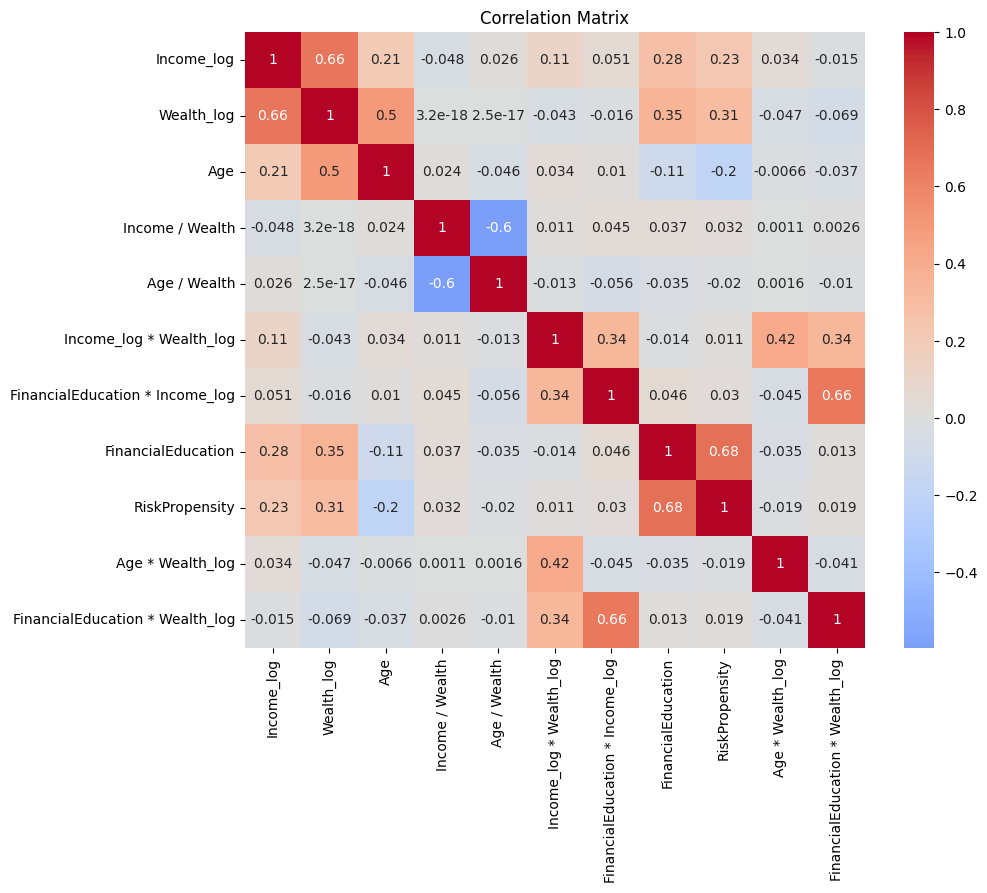

In [182]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_accumulation[feature_kept].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation Matrix')
plt.show()

In [183]:
X_train = X_train[feature_kept.tolist()]
X_test = X_test[feature_kept.tolist()]

In [184]:
# Train model (e.g., Random Forest)
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[1][:, 1]  # Class 1 only (for recall)

In [185]:
shap_class1 = np.abs(shap_values)
feature_importance = pd.DataFrame({
    'Feature': feature_kept.tolist(),
    'SHAP_Impact': shap_class1  # <-- This is correct!
}).sort_values('SHAP_Impact', ascending=False)

In [186]:
feature_importance

,Feature,SHAP_Impact
0,Income_log,0.143407
1,Wealth_log,0.109955
2,Age,0.050880
3,Income / Wealth,0.050407
5,Income_log * Wealth_log,0.029546
4,Age / Wealth,0.027016
7,FinancialEducation,0.021136
8,RiskPropensity,0.012866
6,FinancialEducation * Income_log,0.012117
10,FinancialEducation * Wealth_log,0.010550


## **Step 2: Recursive Feature Addition (RFA) with Constraints**

In [116]:
selected_features = constrained_rfa(X_train, y_train, model, min_accuracy=0.775, max_features=10)

In [117]:
print("Selected features: ", selected_features)

Selected features:  ['Income_log', 'Wealth_log', 'Income / Family', 'Wealth / Family', 'Age', 'Income_log * Wealth_log', 'Income / Wealth', 'FinancialEducation', 'Age / Wealth', 'RiskPropensity * Wealth_log']


In [118]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [119]:
# Train model (e.g., Random Forest)
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[1][:, 1]  # Class 1 only (for recall)

In [121]:
shap_class1 = np.abs(shap_values)
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'SHAP_Impact': shap_class1  # <-- This is correct!
}).sort_values('SHAP_Impact', ascending=False)
feature_importance

,Feature,SHAP_Impact
0,Income_log,0.110592
2,Income / Family,0.083394
1,Wealth_log,0.075707
3,Wealth / Family,0.068303
6,Income / Wealth,0.035658
4,Age,0.029821
5,Income_log * Wealth_log,0.022668
8,Age / Wealth,0.021953
7,FinancialEducation,0.015982
9,RiskPropensity * Wealth_log,0.012442


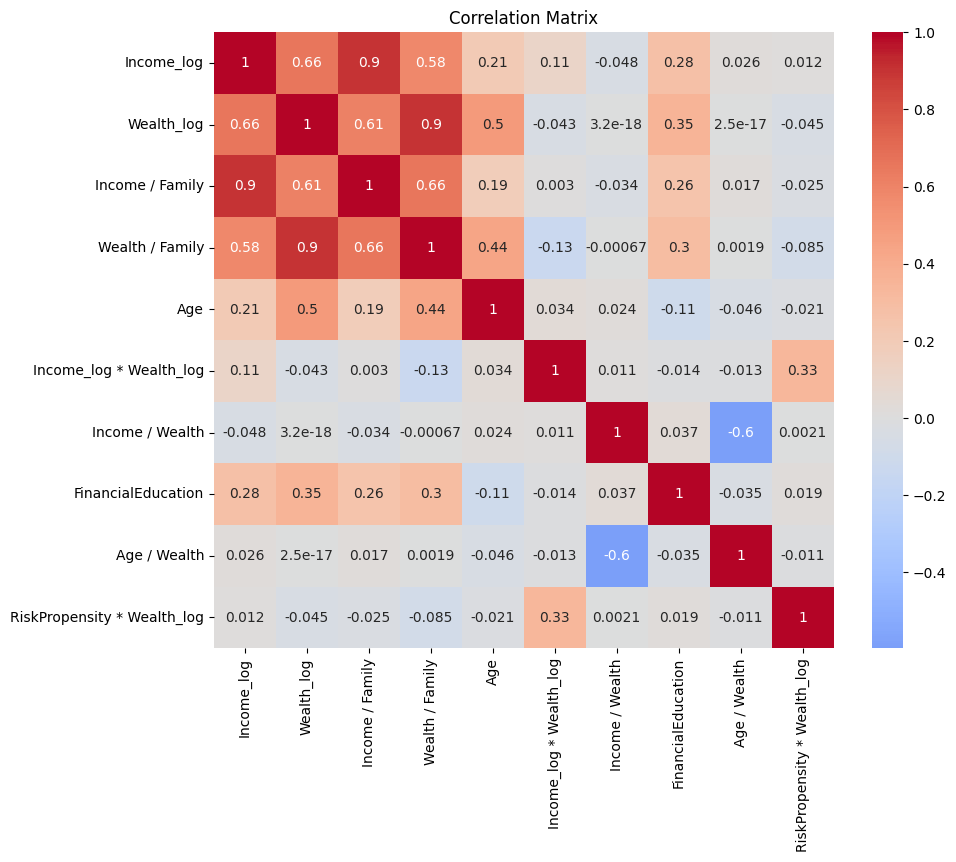

In [124]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_accumulation[selected_features].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation Matrix')
plt.show()